In [11]:
!pip install pandas xgboost kaggle scikit-learn

In [12]:
import platform
print(platform.architecture())

('64bit', '')


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

data = pd.read_csv('./data/train.csv')

# 모델 돌릴 수 있도록 type만 바꿔주는 것: data에서 pitch_type 열은 label encoding으로 바꾸고, stand, p_throws, inning_topbot, if_fielding_alignment, of_fielding_alignment 열은 one-hot encoding으로 숫자로 바꾸기
label_encoder = LabelEncoder()
data['pitch_type'] = label_encoder.fit_transform(data['pitch_type'])

# one-hot encoding
onehot_encoder = OneHotEncoder(sparse_output=False)
columns_to_encode = ['stand', 'p_throws', 'inning_topbot', 'if_fielding_alignment', 'of_fielding_alignment']
encoded_columns = pd.DataFrame(onehot_encoder.fit_transform(data[columns_to_encode]))

encoded_columns.columns = onehot_encoder.get_feature_names_out(columns_to_encode)
data = pd.concat([data.drop(columns_to_encode, axis=1), encoded_columns], axis=1)

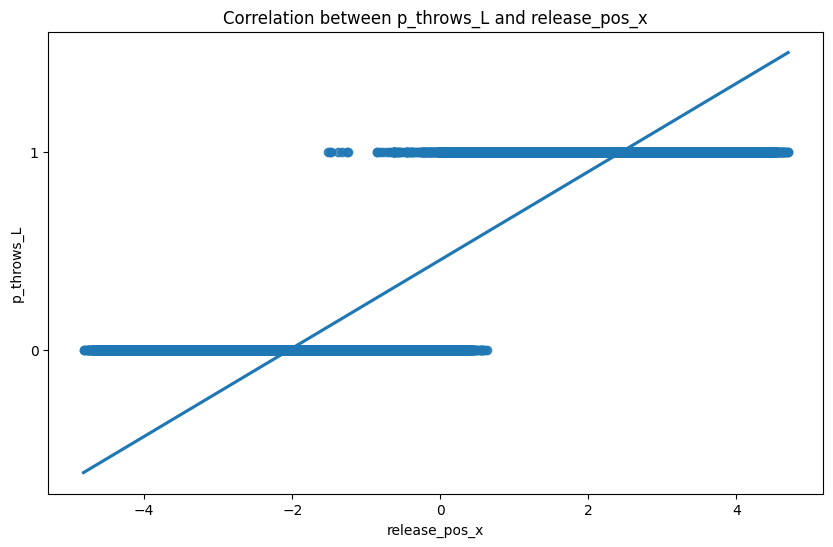

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize=(10, 6))

sns.regplot(x='release_pos_x', y='p_throws_L', data=data, logistic=False, ci=None)

plt.title('Correlation between p_throws_L and release_pos_x')
plt.xlabel('release_pos_x')
plt.ylabel('p_throws_L')
plt.yticks([0, 1])

plt.show()

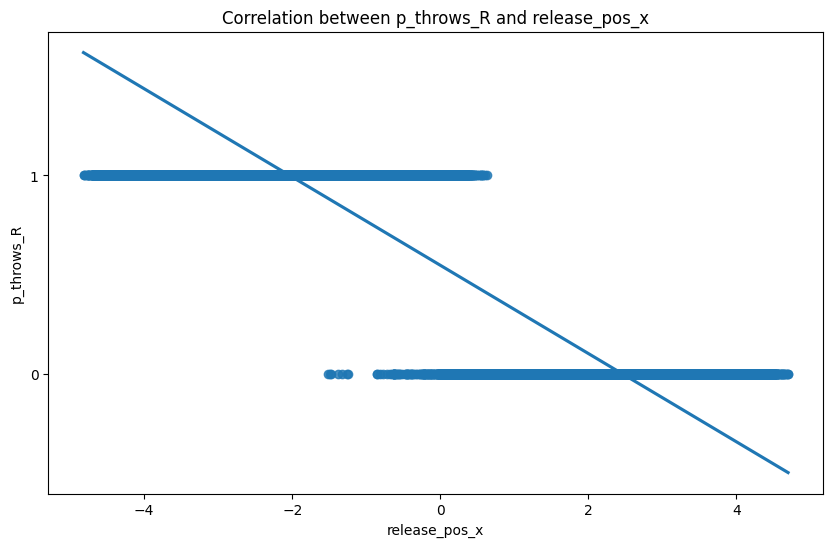

In [3]:
plt.figure(figsize=(10, 6))

sns.regplot(x='release_pos_x', y='p_throws_R', data=data, logistic=False, ci=None)

plt.title('Correlation between p_throws_R and release_pos_x')
plt.xlabel('release_pos_x')
plt.ylabel('p_throws_R')
plt.yticks([0, 1])

plt.show()

# 외생변수

### plate_x와 plate_y를 병합하여 좌표 형식의 피쳐 생성
### 1. 스트라이크 존 중심 (0,2.49)에서의 거리 계산

In [14]:
import pandas as pd
import numpy as np

# data['Coordinates'] = data.apply(lambda row: f"({row['plate_x']}, {row['plate_z']})", axis=1)
data['Distance_from_center'] = np.sqrt((data['plate_x'] - 0)**2 + (data['plate_z'] - 2.49)**2)

print(data['Distance_from_center'])
print('===요약===')
print(data['Distance_from_center'].describe())

0         0.520096
1         0.672681
2         0.588727
3         0.833847
4         1.599625
            ...   
291266    1.106933
291267    0.770065
291268    1.170043
291269    1.251000
291270    1.759005
Name: Distance_from_center, Length: 291271, dtype: float64
===요약===
count    291271.000000
mean          1.351643
std           0.637673
min           0.000000
25%           0.901388
50%           1.299885
75%           1.723079
max          10.174045
Name: Distance_from_center, dtype: float64


### 2. 스트라이크 존 라인과의 거리

In [2]:
import pandas as pd
import numpy as np

x_min = -0.71
x_max = 0.71
y_min = 1.6
y_max = 3.38

def distance_to_strike_zone(x, y):
    distance_left = x - x_min
    distance_right = x - x_max
    distance_bottom = y - y_min
    distance_top = y - y_max

    min_distance = min(abs(distance_left), abs(distance_right), abs(distance_bottom), abs(distance_top))

    if x_min < x < x_max and y_min < y < y_max:
        # 내부에 있으면 음수로 반환
        if min_distance == abs(distance_left):
            return -distance_left
        elif min_distance == abs(distance_right):
            return -distance_right
        elif min_distance == abs(distance_bottom):
            return -distance_bottom
        else:
            return -distance_top
    else:
        # 외부에 있으면 양수로 반환
        if min_distance == abs(distance_left):
            return distance_left
        elif min_distance == abs(distance_right):
            return distance_right
        elif min_distance == abs(distance_bottom):
            return distance_bottom
        else:
            return distance_top
        
data['Distance_from_line'] = data.apply(lambda row: distance_to_strike_zone(row['plate_x'], row['plate_z']), axis=1)

data['Distance_from_line']


0        -0.37
1         0.05
2         0.16
3        -0.12
4        -0.19
          ... 
291266   -0.31
291267   -0.10
291268    0.46
291269   -0.54
291270    0.14
Name: Distance_from_line, Length: 291271, dtype: float64

In [16]:
data['Distance_from_line'].describe()

count    291271.000000
mean         -0.009273
std           0.372413
min          -2.790000
25%          -0.260000
50%          -0.010000
75%           0.240000
max           4.450000
Name: Distance_from_line, dtype: float64

### 3. release_speed 범주 나누기

In [17]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

bins = [32, 68, 75, 82, 89, 95, 104]
labels = ['32-68', '68-75', '75-82', '82-89', '89-95', '95-104']

release_speed_binned = pd.cut(data['release_speed'], bins=bins, labels=labels, right=False)
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(release_speed_binned.values.reshape(-1, 1))

encoded_columns = encoder.get_feature_names_out(['release_speed'])

encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns)

data = pd.concat([data, encoded_df], axis=1)
print(data[['release_speed', 'release_speed_32-68', 'release_speed_68-75', 'release_speed_75-82', 'release_speed_82-89','release_speed_89-95', 'release_speed_95-104']].head())

   release_speed  release_speed_32-68  release_speed_68-75  \
0           90.6                  0.0                  0.0   
1           92.6                  0.0                  0.0   
2           91.6                  0.0                  0.0   
3           93.5                  0.0                  0.0   
4           89.3                  0.0                  0.0   

   release_speed_75-82  release_speed_82-89  release_speed_89-95  \
0                  0.0                  0.0                  1.0   
1                  0.0                  0.0                  1.0   
2                  0.0                  0.0                  1.0   
3                  0.0                  0.0                  1.0   
4                  0.0                  0.0                  1.0   

   release_speed_95-104  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  


In [18]:
import pandas as pd

bins = range(30, 105, 2)
data['release_speed_binned'] = pd.cut(data['release_speed'], bins=bins)

count_per_bin = data['release_speed_binned'].value_counts().sort_index()
print(count_per_bin)

release_speed_binned
(30, 32]          0
(32, 34]          3
(34, 36]          4
(36, 38]          6
(38, 40]          8
(40, 42]         11
(42, 44]         26
(44, 46]         26
(46, 48]         40
(48, 50]         23
(50, 52]         29
(52, 54]         29
(54, 56]         43
(56, 58]         34
(58, 60]         29
(60, 62]         42
(62, 64]         46
(64, 66]         55
(66, 68]         73
(68, 70]        266
(70, 72]       1175
(72, 74]       2047
(74, 76]       3247
(76, 78]       6982
(78, 80]      12556
(80, 82]      17309
(82, 84]      22035
(84, 86]      26559
(86, 88]      27509
(88, 90]      25234
(90, 92]      32364
(92, 94]      47133
(94, 96]      40131
(96, 98]      19117
(98, 100]      5907
(100, 102]     1092
(102, 104]       81
Name: count, dtype: int64


## 전처리

#### 베이스 주자 유무 상테 bool -> int

In [19]:
data['on_3b'] = data['on_3b'].astype(int)
data['on_2b'] = data['on_2b'].astype(int)
data['on_1b'] = data['on_1b'].astype(int)

print(data[['on_3b', 'on_2b', 'on_1b']].head())

   on_3b  on_2b  on_1b
0      0      0      0
1      0      0      0
2      0      0      0
3      0      0      0
4      0      0      0


In [20]:
data = data.drop('release_speed_binned', axis=1)

## 전략

### 1. Feature Scaling

#### 피처들의 스케일 확인

<Axes: >

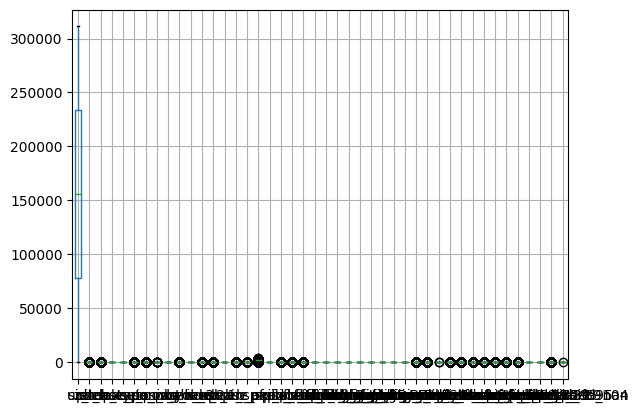

In [21]:
data.boxplot()

In [22]:
features = data.select_dtypes(include=[float, int]).columns
for column in features:
    print(f"{column}: Min = {data[column].min()}, Max = {data[column].max()}")

uid: Min = 0, Max = 311270
sz_top: Min = 2.52, Max = 4.24
sz_bot: Min = 0.77, Max = 2.2
pitch_type: Min = 0, Max = 11
release_pos_x: Min = -4.82, Max = 4.7
release_pos_y: Min = 48.37, Max = 57.53
release_pos_z: Min = 0.86, Max = 7.66
inning: Min = 1, Max = 15
outs_when_up: Min = 0, Max = 2
balls: Min = 0, Max = 4
strikes: Min = 0, Max = 2
on_3b: Min = 0, Max = 1
on_2b: Min = 0, Max = 1
on_1b: Min = 0, Max = 1
release_speed: Min = 32.3, Max = 104.0
spin_axis: Min = 0, Max = 360
release_spin_rate: Min = 89, Max = 3593
pfx_x: Min = -2.38, Max = 2.57
pfx_z: Min = -2.0, Max = 2.8
plate_x: Min = -8.66, Max = 4.61
plate_z: Min = -3.83, Max = 10.22
is_strike: Min = 0, Max = 1
stand_L: Min = 0.0, Max = 1.0
stand_R: Min = 0.0, Max = 1.0
p_throws_L: Min = 0.0, Max = 1.0
p_throws_R: Min = 0.0, Max = 1.0
inning_topbot_Bot: Min = 0.0, Max = 1.0
inning_topbot_Top: Min = 0.0, Max = 1.0
if_fielding_alignment_Infield shift: Min = 0.0, Max = 1.0
if_fielding_alignment_Standard: Min = 0.0, Max = 1.0
if_fie

In [23]:
data['release_spin_rate'].describe()

count    291271.000000
mean       2248.413931
std         322.155628
min          89.000000
25%        2099.000000
50%        2272.000000
75%        2439.000000
max        3593.000000
Name: release_spin_rate, dtype: float64

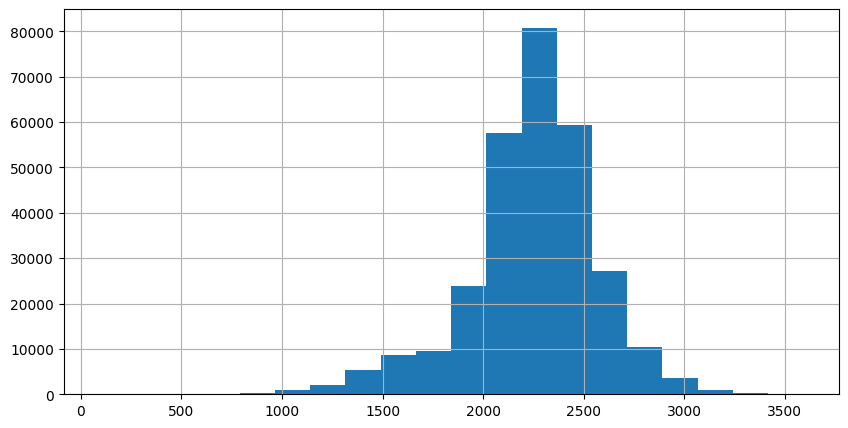

In [24]:
import matplotlib.pyplot as plt 

data['release_spin_rate'].hist(bins=20, figsize=(10, 5))
plt.show()

In [25]:
data['spin_axis'].describe()

count    291271.000000
mean        174.987726
std          72.426845
min           0.000000
25%         131.000000
50%         199.000000
75%         222.000000
max         360.000000
Name: spin_axis, dtype: float64

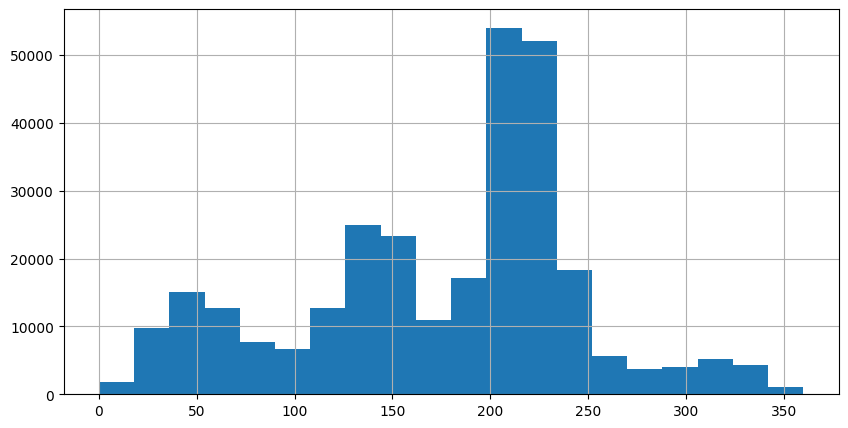

In [26]:
import matplotlib.pyplot as plt

data['spin_axis'].hist(bins=20, figsize=(10, 5))
plt.show()

### scaling

In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# StandardScaler와 MinMaxScaler 객체 생성
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# 'release_spin_rate' -> Standard Scaling
data['release_spin_rate_scaled'] = standard_scaler.fit_transform(data[['release_spin_rate']])

# 'spin_axis' -> Min-Max Scaling
data['spin_axis_scaled'] = minmax_scaler.fit_transform(data[['spin_axis']])

print(data[['release_spin_rate', 'release_spin_rate_scaled', 'spin_axis', 'spin_axis_scaled']].head())

   release_spin_rate  release_spin_rate_scaled  spin_axis  spin_axis_scaled
0               2192                 -0.175114        192          0.533333
1               2209                 -0.122345        196          0.544444
2               2314                  0.203585        187          0.519444
3               2235                 -0.041638        194          0.538889
4               2314                  0.203585        184          0.511111


In [28]:
data = data.drop(['release_spin_rate', 'spin_axis'], axis=1)

## 치우친 데이터 필터링

In [29]:
import pandas as pd

def unique_value_ratios(data):
    for column in data.columns:
        print(f"Feature: {column}")
        value_counts = data[column].value_counts(normalize=True)
        print(value_counts)
        print("\n")

unique_value_ratios(data)

Feature: uid
uid
0         0.000003
207476    0.000003
207482    0.000003
207481    0.000003
207480    0.000003
            ...   
103812    0.000003
103813    0.000003
103814    0.000003
103815    0.000003
311270    0.000003
Name: proportion, Length: 291271, dtype: float64


Feature: sz_top
sz_top
3.37    0.021684
3.40    0.020860
3.41    0.020647
3.47    0.020503
3.38    0.020266
          ...   
4.22    0.000003
4.24    0.000003
2.52    0.000003
2.53    0.000003
4.20    0.000003
Name: proportion, Length: 170, dtype: float64


Feature: sz_bot
sz_bot
1.60    0.036420
1.59    0.034772
1.56    0.034401
1.63    0.033972
1.62    0.033900
          ...   
0.77    0.000003
1.03    0.000003
0.99    0.000003
0.88    0.000003
0.89    0.000003
Name: proportion, Length: 123, dtype: float64


Feature: pitch_type
pitch_type
6     0.338808
11    0.198605
10    0.165217
0     0.104490
2     0.089388
5     0.069571
8     0.019113
7     0.012322
4     0.001727
3     0.000604
1     0.000127
9     0.000

### 95%컷

In [30]:
# # of_fielding_alignment_4th outfielder, of_fielding_alignment_Extreme outfield shift, of_fielding_alignment_Strategic, release_speed_32-68, release_speed_68-75, release_speed_nan
# ### ** 질문 ** : 범주로 나눈 피처도 필터링하는게 맞나?

# # # 1. 범주로 나눈 피처 포함 필터링
# # data = data.drop(['of_fielding_alignment_4th outfielder', 'of_fielding_alignment_Extreme outfield shift', 'of_fielding_alignment_Strategic', 'release_speed_68-75', 'release_speed_nan', 'release_speed_32-68', 'release_speed_68-75'], axis=1)

# # 2. 범주로 나눈 피처 미포함 필터링
# data = data.drop(['of_fielding_alignment_4th outfielder', 'of_fielding_alignment_Extreme outfield shift', 'of_fielding_alignment_Strategic'], axis=1)

### 97%컷

In [31]:
# of_fielding_alignment_4th outfielder, of_fielding_alignment_Extreme outfield shift, of_fielding_alignment_Strategic, release_speed_32-68, release_speed_68-75, release_speed_nan

# 범주로 나눈 피처 미포함 필터링
data = data.drop(['of_fielding_alignment_4th outfielder', 'of_fielding_alignment_Extreme outfield shift'], axis=1)

In [32]:
from collections import Counter

Counter(data['release_speed_nan'].values)
data = data.drop('release_speed_nan', axis = 1)

## Clustering

In [33]:
def inning_cluster(inning):
    if inning <= 3:
        return 0
    elif inning <= 6:
        return 1
    elif inning <= 9:
        return 2
    else:
        return 3
    
data['inning_cluster'] = data['inning'].apply(inning_cluster)
data = data.drop('inning', axis = 1)

## Log Transformation

### 분산 시각화

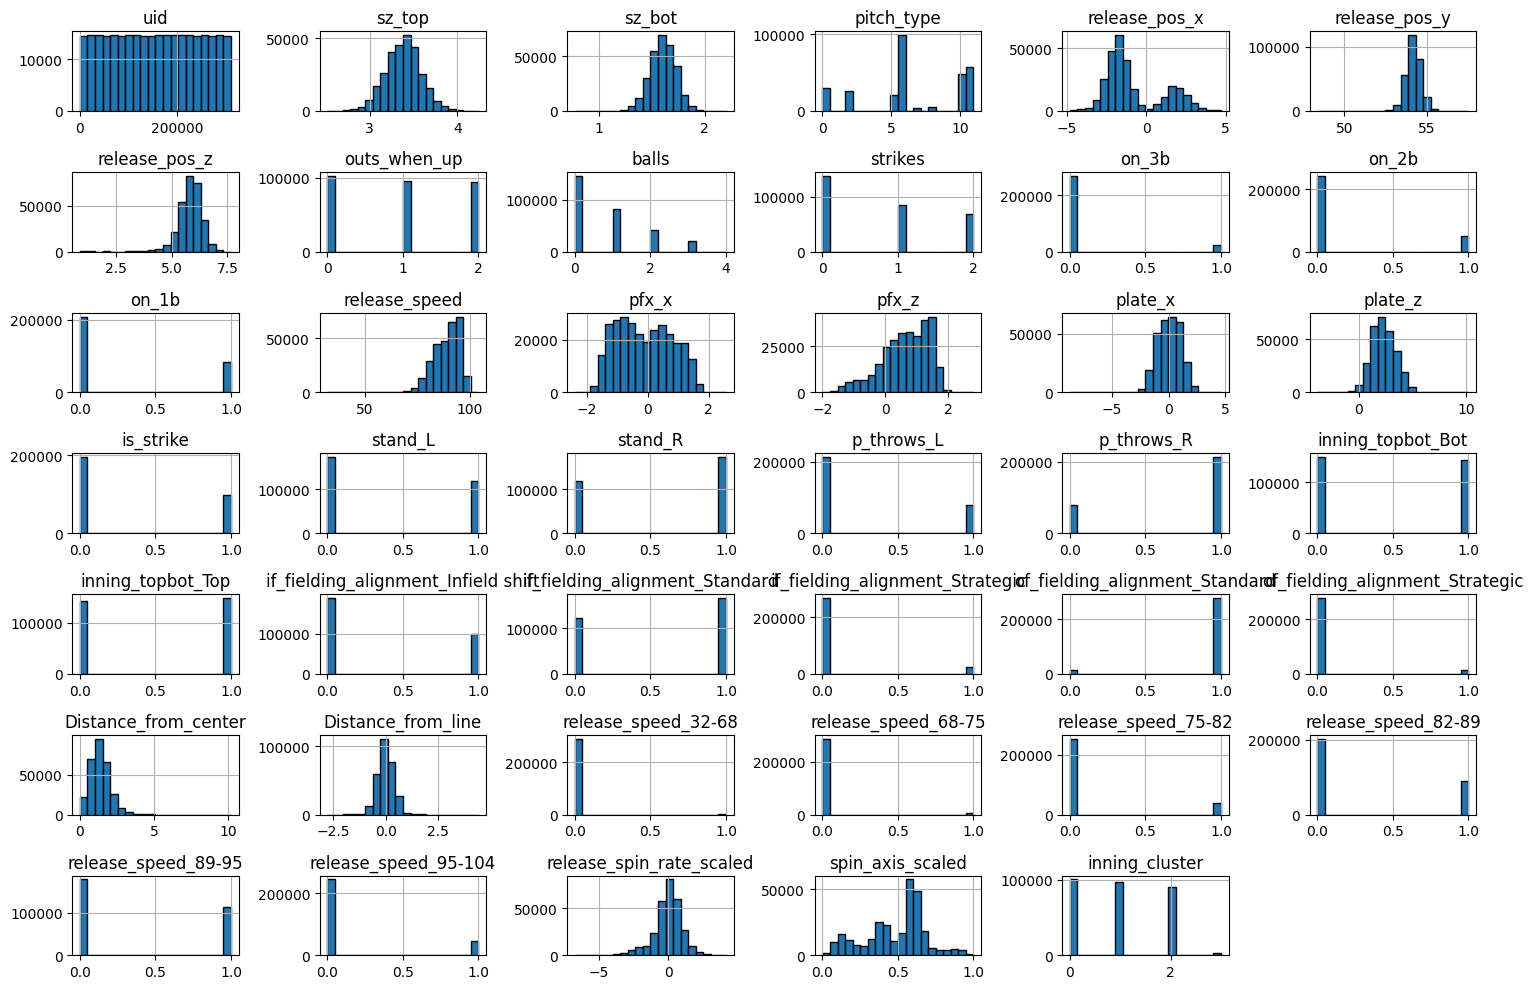

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_histograms(df):
    df.hist(figsize=(15, 10), bins=20, edgecolor='black')
    plt.tight_layout()
    plt.show()

plot_histograms(data)

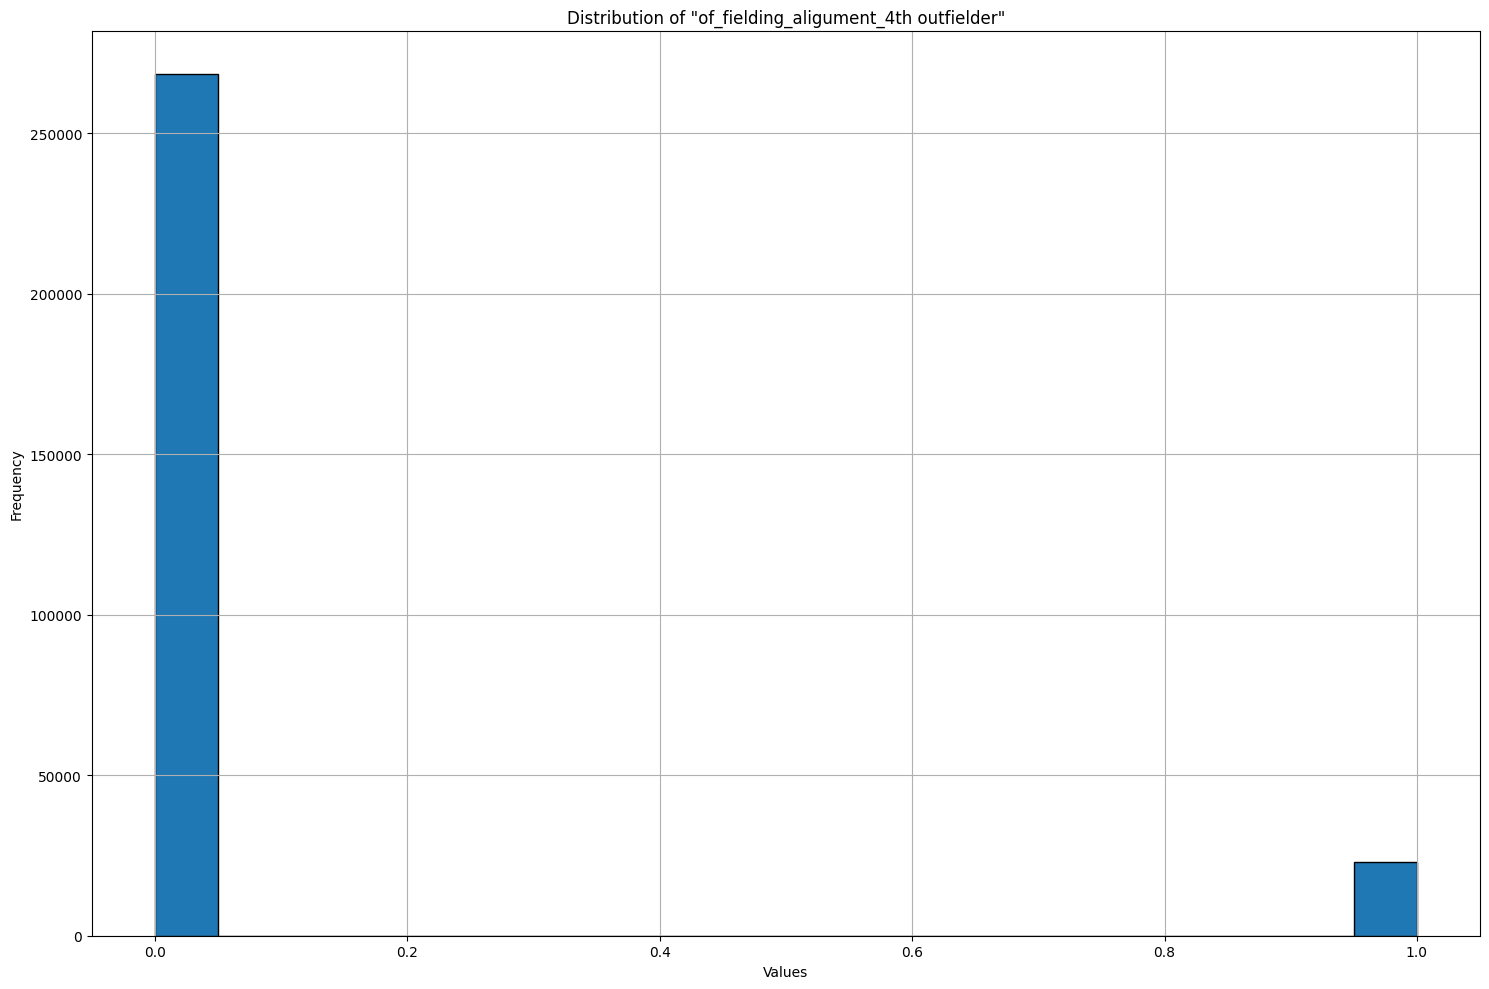

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_histograms(df):
    df['on_3b'] = df['on_3b'].astype(int)
    df['on_3b'].hist(figsize=(15, 10), bins=20, edgecolor='black')
    plt.title('Distribution of "of_fielding_aligument_4th outfielder"')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_histograms(data)

In [36]:
data.columns

Index(['uid', 'sz_top', 'sz_bot', 'pitch_type', 'release_pos_x',
       'release_pos_y', 'release_pos_z', 'outs_when_up', 'balls', 'strikes',
       'on_3b', 'on_2b', 'on_1b', 'release_speed', 'pfx_x', 'pfx_z', 'plate_x',
       'plate_z', 'is_strike', 'stand_L', 'stand_R', 'p_throws_L',
       'p_throws_R', 'inning_topbot_Bot', 'inning_topbot_Top',
       'if_fielding_alignment_Infield shift', 'if_fielding_alignment_Standard',
       'if_fielding_alignment_Strategic', 'of_fielding_alignment_Standard',
       'of_fielding_alignment_Strategic', 'Distance_from_center',
       'Distance_from_line', 'release_speed_32-68', 'release_speed_68-75',
       'release_speed_75-82', 'release_speed_82-89', 'release_speed_89-95',
       'release_speed_95-104', 'release_spin_rate_scaled', 'spin_axis_scaled',
       'inning_cluster'],
      dtype='object')

### 불균형 피처 log transformation
-> 'release_speed', 'release_pos_z', 'pfx_z', 'plate_z', 'release_pos_y'

In [37]:
import numpy as np

In [3]:
# release_speed 피처 로그 변환
min_val = data['release_speed'].min()
if min_val <= 0:
    data['release_speed_log'] = np.log1p(data['release_speed'] - min_val + 1)
else:
    data['release_speed_log'] = np.log1p(data['release_speed'])

print(data[['release_speed', 'release_speed_log']].head())

   release_speed  release_speed_log
0           90.6           4.517431
1           92.6           4.539030
2           91.6           4.528289
3           93.5           4.548600
4           89.3           4.503137


In [39]:
# release_pos_z 피처 로그 변환
min_val = data['release_pos_z'].min()
if min_val <= 0:
    data['release_pos_z_log'] = np.log1p(data['release_pos_z'] - min_val + 1)
else:
    data['release_pos_z_log'] = np.log1p(data['release_pos_z'])

print(data[['release_pos_z', 'release_pos_z_log']].head())

   release_pos_z  release_pos_z_log
0           6.53           2.018895
1           6.39           2.000128
2           6.40           2.001480
3           6.36           1.996060
4           6.40           2.001480


In [4]:
# pfx_z 피처 로그 변환
min_val = data['pfx_z'].min()
if min_val <= 0:
    data['pfx_z_log'] = np.log1p(data['pfx_z'] - min_val + 1)
else:
    data['pfx_z_log'] = np.log1p(data['pfx_z'])

print(data[['pfx_z', 'pfx_z_log']].head())

   pfx_z  pfx_z_log
0   1.68   1.736951
1   1.67   1.735189
2   1.61   1.724551
3   1.79   1.756132
4   1.25   1.658228


In [5]:
# plate_z 피처 로그 변환
min_val = data['plate_z'].min()
if min_val <= 0:
    data['plate_z_log'] = np.log1p(data['plate_z'] - min_val + 1)
else:
    data['plate_z_log'] = np.log1p(data['plate_z'])

print(data[['plate_z', 'plate_z_log']].head())


   plate_z  plate_z_log
0     1.97     2.054124
1     2.62     2.134166
2     2.28     2.093098
3     2.57     2.128232
4     1.41     1.979621


In [6]:
# release_pos_y 피처 로그 변환
min_val = data['release_pos_y'].min()
if min_val <= 0:
    data['release_pos_y_log'] = np.log1p(data['release_pos_y'] - min_val + 1)
else:
    data['release_pos_y_log'] = np.log1p(data['release_pos_y'])

print(data[['release_pos_y', 'release_pos_y_log']].head())

   release_pos_y  release_pos_y_log
0          53.66           4.001132
1          53.57           3.999484
2          53.51           3.998384
3          53.65           4.000949
4          53.74           4.002595


In [43]:
# Distance_from_center 피처 로그 변환
min_val = data['Distance_from_center'].min()
if min_val <= 0:
    data['Distance_from_center_log'] = np.log1p(data['Distance_from_center'] - min_val + 1)
else:
    data['Distance_from_center_log'] = np.log1p(data['Distance_from_center'])

print(data[['Distance_from_center', 'Distance_from_center_log']].head())

   Distance_from_center  Distance_from_center_log
0              0.520096                  0.924297
1              0.672681                  0.983082
2              0.588727                  0.951166
3              0.833847                  1.041635
4              1.599625                  1.280830


## log transformation 후 분산 시각화

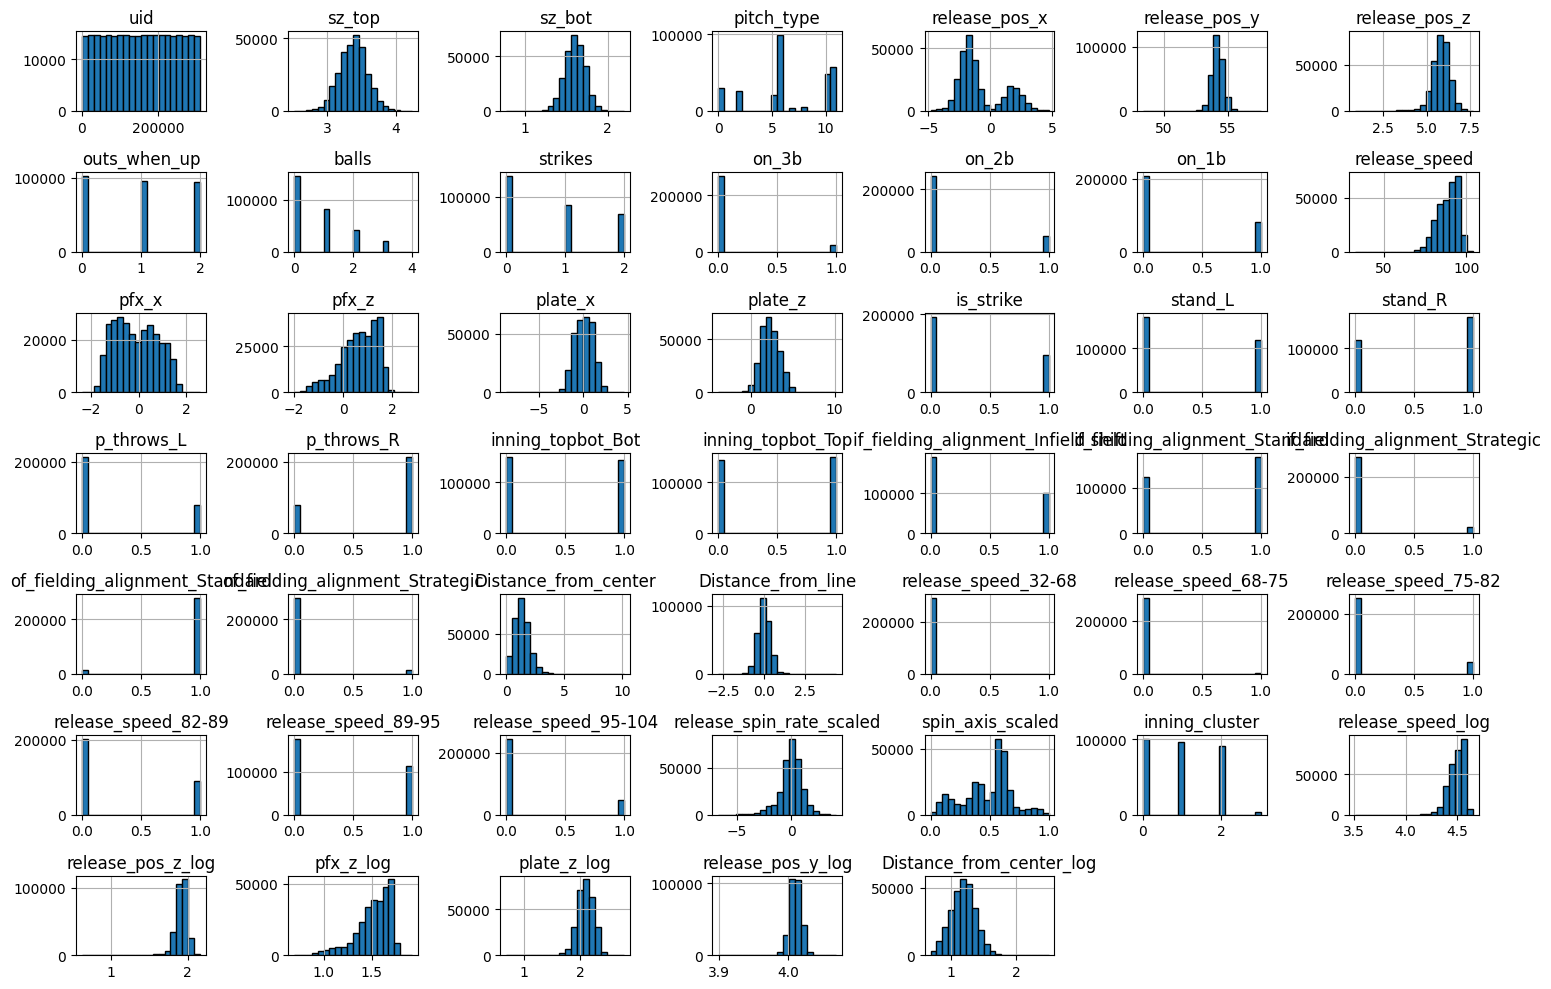

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_histograms(df):
    df.hist(figsize=(15, 10), bins=20, edgecolor='black')
    plt.tight_layout()
    plt.show()

plot_histograms(data)

## Feature Importance

In [45]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data_without_distence_from_center = data
# data_without_distence_from_center = data_without_distence_from_center.drop('Distance_from_center', axis=1)
X = data_without_distence_from_center.drop(columns=['is_strike'])
y = data_without_distence_from_center['is_strike']

train_data_without_distence_from_center, val_data_without_distence_from_center, train_labels, val_labels = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 학습
model = xgb.XGBClassifier(eval_metric='logloss')
model.fit(train_data_without_distence_from_center, train_labels)

# 피처 중요도 계산
importance = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                                Feature  Importance
29                 Distance_from_center    0.755773
30                   Distance_from_line    0.023249
9                               strikes    0.020100
18                              stand_L    0.018814
17                              plate_z    0.014897
16                              plate_x    0.013777
2                                sz_bot    0.010020
8                                 balls    0.009045
20                           p_throws_L    0.008877
1                                sz_top    0.008797
4                         release_pos_x    0.008290
12                                on_1b    0.005928
27       of_fielding_alignment_Standard    0.005913
6                         release_pos_z    0.005644
13                        release_speed    0.005360
28      of_fielding_alignment_Strategic    0.004981
0                                   uid    0.004678
11                                on_2b    0.004645
10          

In [46]:
# import pandas as pd
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt

# data_without_distence_from_center = data
# # data_without_distence_from_center = data_without_distence_from_center.drop('Distance_from_center', axis=1)
# X = data_without_distence_from_center.drop(columns=['is_strike'])
# y = data_without_distence_from_center['is_strike']

# train_data_without_distence_from_center, val_data_without_distence_from_center, train_labels, val_labels = train_test_split(X, y, test_size=0.2, random_state=42)

# # XGBoost 모델 학습
# model = xgb.XGBClassifier(eval_metric='logloss')
# model.fit(train_data_without_distence_from_center, train_labels)

# # 피처 중요도 계산
# importance = model.feature_importances_

# importance_df = pd.DataFrame({
#     'Feature': X.columns,
#     'Importance': importance
# }).sort_values(by='Importance', ascending=False)

# print(importance_df)

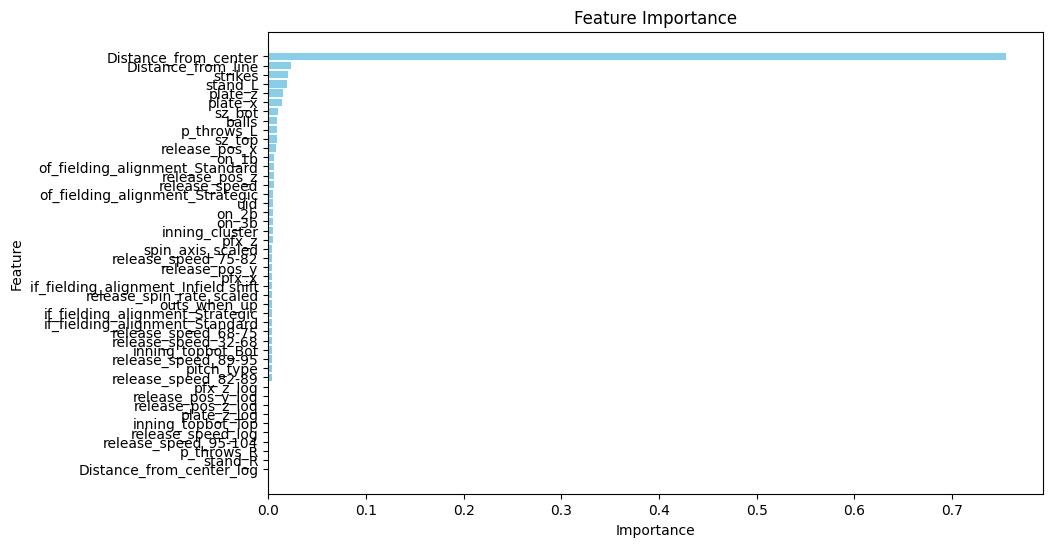

In [47]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # 높은 중요도를 위에 표시
plt.show()

In [48]:
data.columns

Index(['uid', 'sz_top', 'sz_bot', 'pitch_type', 'release_pos_x',
       'release_pos_y', 'release_pos_z', 'outs_when_up', 'balls', 'strikes',
       'on_3b', 'on_2b', 'on_1b', 'release_speed', 'pfx_x', 'pfx_z', 'plate_x',
       'plate_z', 'is_strike', 'stand_L', 'stand_R', 'p_throws_L',
       'p_throws_R', 'inning_topbot_Bot', 'inning_topbot_Top',
       'if_fielding_alignment_Infield shift', 'if_fielding_alignment_Standard',
       'if_fielding_alignment_Strategic', 'of_fielding_alignment_Standard',
       'of_fielding_alignment_Strategic', 'Distance_from_center',
       'Distance_from_line', 'release_speed_32-68', 'release_speed_68-75',
       'release_speed_75-82', 'release_speed_82-89', 'release_speed_89-95',
       'release_speed_95-104', 'release_spin_rate_scaled', 'spin_axis_scaled',
       'inning_cluster', 'release_speed_log', 'release_pos_z_log', 'pfx_z_log',
       'plate_z_log', 'release_pos_y_log', 'Distance_from_center_log'],
      dtype='object')

### 변수 정리 - 기준 0.02 이상

In [49]:
# columns_to_keep = ['plate_x', 'plate_z', 'strikes', 'stand_L', 'is_strike']
# data = data[columns_to_keep]

### 변수 정리 - 기준 0.01 이상

In [50]:
# columns_to_keep = ['uid', 'plate_x', 'plate_z', 'strikes', 'stand_L', 'p_throws_L', 'Distance_from_line', 'sz_bot', 'balls', 'sz_top', 'release_pos_x', 'is_strike']
# data = data[columns_to_keep]

## Kmeans clustering

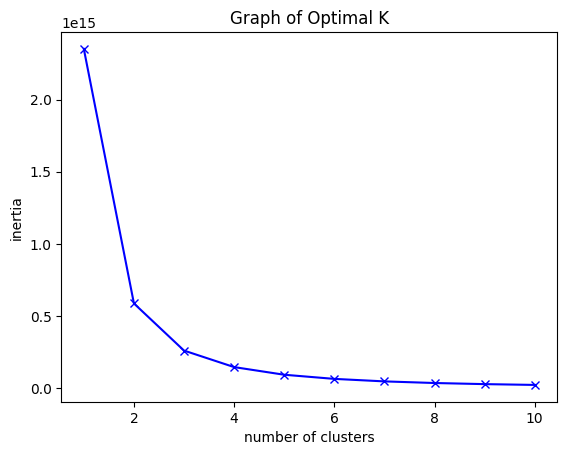

In [51]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

# 그래프 그리기
plt.plot(K, inertia, 'bx-')
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.title('Graph of Optimal K')
plt.show()

-> 3개로 잡자!

In [52]:
data.columns

Index(['uid', 'sz_top', 'sz_bot', 'pitch_type', 'release_pos_x',
       'release_pos_y', 'release_pos_z', 'outs_when_up', 'balls', 'strikes',
       'on_3b', 'on_2b', 'on_1b', 'release_speed', 'pfx_x', 'pfx_z', 'plate_x',
       'plate_z', 'is_strike', 'stand_L', 'stand_R', 'p_throws_L',
       'p_throws_R', 'inning_topbot_Bot', 'inning_topbot_Top',
       'if_fielding_alignment_Infield shift', 'if_fielding_alignment_Standard',
       'if_fielding_alignment_Strategic', 'of_fielding_alignment_Standard',
       'of_fielding_alignment_Strategic', 'Distance_from_center',
       'Distance_from_line', 'release_speed_32-68', 'release_speed_68-75',
       'release_speed_75-82', 'release_speed_82-89', 'release_speed_89-95',
       'release_speed_95-104', 'release_spin_rate_scaled', 'spin_axis_scaled',
       'inning_cluster', 'release_speed_log', 'release_pos_z_log', 'pfx_z_log',
       'plate_z_log', 'release_pos_y_log', 'Distance_from_center_log'],
      dtype='object')

In [53]:
data['spin_axis_scaled']

0         0.533333
1         0.544444
2         0.519444
3         0.538889
4         0.511111
            ...   
291266    0.405556
291267    0.138889
291268    0.602778
291269    0.641667
291270    0.572222
Name: spin_axis_scaled, Length: 291271, dtype: float64

### 변수 기준 - feature importance

In [54]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# import xgboost as xgb
# from sklearn.metrics import log_loss
# from itertools import combinations
# from sklearn.cluster import KMeans

# import warnings
# warnings.filterwarnings('ignore')

# #######
# # clustered_columns_candidate = ['pfx_x', 'pfx_z', 'release_pos_x', 'spin_axis', 'pitch_type']
# # for i in range(1, 6): 
# #     for columns in combinations(clustered_columns_candidate, i):
# #         clustered_data = data[list(columns)]
# #         for n_clusters in range(3, 8):
# #             kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# #             data['cluster'] = kmeans.fit_predict(clustered_data)
# #             model = train_model_eval(data, clustered_columns=list(columns), n_clusters = n_clusters)
# #             data.drop('cluster', axis=1, inplace=True)

# #######

# # variables = ['Distance_from_center', 'plate_x', 'plate_z', 'strikes', 'stand_L'] # 기준:feature importance(Distance_from_center 제외)
# variables = ['balls', 'plate_x', 'plate_z', 'strikes', 'stand_L'] # 기준:feature importance(Distance_from_center 제외)

# results = []

# # 기준 모델: 클러스터링 없이 전체 데이터를 사용한 모델의 Log Loss 계산
# train_data, val_data, train_labels, val_labels = train_test_split(
#     # data[variables],
#     data.drop('is_strike', axis = 1), 
#     data['is_strike'],
#     test_size=0.2,
#     random_state=42
# )

# baseline_model = xgb.XGBClassifier(eval_metric='logloss')
# baseline_model.fit(train_data, train_labels)

# baseline_val_preds = baseline_model.predict_proba(val_data)

# baseline_logloss = log_loss(val_labels, baseline_val_preds)
# print(f'Baseline Log Loss (without clustering): {baseline_logloss}')

# # 변수 조합을 찾기 위한 루프
# for n in range(1, len(variables) + 1):
#     for combo in combinations(variables, n):
#         subset = data[list(combo)]

#         # 클러스터 개수를 3에서 7까지 테스트
#         for n_clusters in range(3, 8):
#             kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
#             kmeans.fit(subset)

#             data['cluster_label'] = kmeans.labels_

#             # 클러스터 레이블을 추가한 전체 변수 사용하여 학습 및 검증 데이터 분할
#             train_data, val_data, train_labels, val_labels = train_test_split(
#                 # data[variables + ['cluster_label']],
#                 data.drop('is_strike', axis = 1), 
#                 data['is_strike'],
#                 test_size=0.2,
#                 random_state=42
#             )

#             model = xgb.XGBClassifier(eval_metric='logloss')
#             model.fit(train_data, train_labels)

#             val_preds = model.predict_proba(val_data)

#             logloss = log_loss(val_labels, val_preds)
#             print(f'Combination: {combo}, Clusters: {n_clusters}, Log Loss: {logloss}')

#             results.append((combo, n_clusters, logloss))

# # log loss 기준으로 결과를 정렬하여 상위 10개 추출
# top_10_results = sorted(results, key=lambda x: x[2])[:10]

# print("\nTop 10 Combinations by Log Loss:")
# for rank, (combo, n_clusters, logloss) in enumerate(top_10_results, start=1):
#     print(f"Rank {rank}: Combination: {combo}, Clusters: {n_clusters}, Log Loss: {logloss}")

# print(f'\nBaseline Log Loss (without clustering): {baseline_logloss}')

In [55]:
Baseline Log Loss (without clustering): 0.15855367704290024
Combination: ('Distance_from_center',), Clusters: 3, Log Loss: 0.15843858395134955
Combination: ('Distance_from_center',), Clusters: 4, Log Loss: 0.1588136999893529
Combination: ('Distance_from_center',), Clusters: 5, Log Loss: 0.15880748449455248
Combination: ('Distance_from_center',), Clusters: 6, Log Loss: 0.15871955568504334
Combination: ('Distance_from_center',), Clusters: 7, Log Loss: 0.15885230327908914
Combination: ('plate_x',), Clusters: 3, Log Loss: 0.1586451670108097

SyntaxError: invalid syntax (415852275.py, line 1)

### 변수 기준 - 용득 오빠 코드

In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# import xgboost as xgb
# from sklearn.metrics import log_loss
# from itertools import combinations
# from sklearn.cluster import KMeans

# import warnings
# warnings.filterwarnings('ignore')

# #######
# # clustered_columns_candidate = ['pfx_x', 'pfx_z', 'release_pos_x', 'spin_axis', 'pitch_type']
# # for i in range(1, 6): 
# #     for columns in combinations(clustered_columns_candidate, i):
# #         clustered_data = data[list(columns)]
# #         for n_clusters in range(3, 8):
# #             kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# #             data['cluster'] = kmeans.fit_predict(clustered_data)
# #             model = train_model_eval(data, clustered_columns=list(columns), n_clusters = n_clusters)
# #             data.drop('cluster', axis=1, inplace=True)

# #######

# variables = ['pfx_x', 'pfx_z', 'release_pos_x', 'spin_axis', 'pitch_type']

# results = []

# # 기준 모델: 클러스터링 없이 전체 데이터를 사용한 모델의 Log Loss 계산
# train_data, val_data, train_labels, val_labels = train_test_split(
#     # data[variables],
#     data.drop('is_strike', axis = 1), 
#     data['is_strike'],
#     test_size=0.2,
#     random_state=42
# )

# baseline_model = xgb.XGBClassifier(eval_metric='logloss')
# baseline_model.fit(train_data, train_labels)

# baseline_val_preds = baseline_model.predict_proba(val_data)

# baseline_logloss = log_loss(val_labels, baseline_val_preds)
# print(f'Baseline Log Loss (without clustering): {baseline_logloss}')

# # 변수 조합을 찾기 위한 루프
# for n in range(1, len(variables) + 1):
#     for combo in combinations(variables, n):
#         subset = data[list(combo)]

#         # 클러스터 개수를 3에서 7까지 테스트
#         for n_clusters in range(3, 8):
#             kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
#             kmeans.fit(subset)

#             data['cluster_label'] = kmeans.labels_

#             # 클러스터 레이블을 추가한 전체 변수 사용하여 학습 및 검증 데이터 분할
#             train_data, val_data, train_labels, val_labels = train_test_split(
#                 # data[variables + ['cluster_label']],
#                 data.drop('is_strike', axis = 1), 
#                 data['is_strike'],
#                 test_size=0.2,
#                 random_state=42
#             )

#             model = xgb.XGBClassifier(eval_metric='logloss')
#             model.fit(train_data, train_labels)

#             val_preds = model.predict_proba(val_data)

#             logloss = log_loss(val_labels, val_preds)
#             print(f'Combination: {combo}, Clusters: {n_clusters}, Log Loss: {logloss}')

#             results.append((combo, n_clusters, logloss))

# # log loss 기준으로 결과를 정렬하여 상위 10개 추출
# top_10_results = sorted(results, key=lambda x: x[2])[:10]

# print("\nTop 10 Combinations by Log Loss:")
# for rank, (combo, n_clusters, logloss) in enumerate(top_10_results, start=1):
#     print(f"Rank {rank}: Combination: {combo}, Clusters: {n_clusters}, Log Loss: {logloss}")

# print(f'\nBaseline Log Loss (without clustering): {baseline_logloss}')

### 변수 기준 : 임의의 기준

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import log_loss
from itertools import combinations
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

#######
# clustered_columns_candidate = ['pfx_x', 'pfx_z', 'release_pos_x', 'spin_axis', 'pitch_type']
# for i in range(1, 6): 
#     for columns in combinations(clustered_columns_candidate, i):
#         clustered_data = data[list(columns)]
#         for n_clusters in range(3, 8):
#             kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#             data['cluster'] = kmeans.fit_predict(clustered_data)
#             model = train_model_eval(data, clustered_columns=list(columns), n_clusters = n_clusters)
#             data.drop('cluster', axis=1, inplace=True)

#######

variables = ['Distance_from_line', 'spin_axis_scaled', 'pfx_x', 'pfx_z_log', 'release_speed_log']

results = []

# 기준 모델: 클러스터링 없이 전체 데이터를 사용한 모델의 Log Loss 계산
train_data, val_data, train_labels, val_labels = train_test_split(
    # data[variables],
    data.drop('is_strike', axis = 1), 
    data['is_strike'],
    test_size=0.2,
    random_state=42
)

baseline_model = xgb.XGBClassifier(eval_metric='logloss')
baseline_model.fit(train_data, train_labels)

baseline_val_preds = baseline_model.predict_proba(val_data)

baseline_logloss = log_loss(val_labels, baseline_val_preds)
print(f'Baseline Log Loss (without clustering): {baseline_logloss}')

# 변수 조합을 찾기 위한 루프
for n in range(1, len(variables) + 1):
    for combo in combinations(variables, n):
        subset = data[list(combo)]

        # 클러스터 개수를 3에서 7까지 테스트
        for n_clusters in range(3, 4):
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            kmeans.fit(subset)

            data['cluster_label'] = kmeans.labels_

            # 클러스터 레이블을 추가한 전체 변수 사용하여 학습 및 검증 데이터 분할
            train_data, val_data, train_labels, val_labels = train_test_split(
                # data[variables + ['cluster_label']],
                data.drop('is_strike', axis = 1), 
                data['is_strike'],
                test_size=0.2,
                random_state=42
            )

            model = xgb.XGBClassifier(eval_metric='logloss')
            model.fit(train_data, train_labels)

            val_preds = model.predict_proba(val_data)

            logloss = log_loss(val_labels, val_preds)
            print(f'Combination: {combo}, Clusters: {n_clusters}, Log Loss: {logloss}')

            results.append((combo, n_clusters, logloss))

# log loss 기준으로 결과를 정렬하여 상위 10개 추출
top_10_results = sorted(results, key=lambda x: x[2])[:10]

print("\nTop 10 Combinations by Log Loss:")
for rank, (combo, n_clusters, logloss) in enumerate(top_10_results, start=1):
    print(f"Rank {rank}: Combination: {combo}, Clusters: {n_clusters}, Log Loss: {logloss}")

print(f'\nBaseline Log Loss (without clustering): {baseline_logloss}')

Baseline Log Loss (without clustering): 0.14707411958661556
Combination: ('Distance_from_line',), Clusters: 3, Log Loss: 0.14707411958661556
Combination: ('spin_axis_scaled',), Clusters: 3, Log Loss: 0.14710599031822322
Combination: ('pfx_x',), Clusters: 3, Log Loss: 0.14739431733203676
Combination: ('pfx_z_log',), Clusters: 3, Log Loss: 0.14771257253262307
Combination: ('release_speed_log',), Clusters: 3, Log Loss: 0.14759854149716461
Combination: ('Distance_from_line', 'spin_axis_scaled'), Clusters: 3, Log Loss: 0.14704215849099644
Combination: ('Distance_from_line', 'pfx_x'), Clusters: 3, Log Loss: 0.14707411958661556
Combination: ('Distance_from_line', 'pfx_z_log'), Clusters: 3, Log Loss: 0.14728506719350268
Combination: ('Distance_from_line', 'release_speed_log'), Clusters: 3, Log Loss: 0.14654412363095395
Combination: ('spin_axis_scaled', 'pfx_x'), Clusters: 3, Log Loss: 0.14733168622555703
Combination: ('spin_axis_scaled', 'pfx_z_log'), Clusters: 3, Log Loss: 0.14704499089379947

## 구역 비율 수정

In [ ]:
import numpy as np

data['scaled_ofset_x'] = np.absolute(data['plate_x'])
data['scaled_ofset_z'] = np.absolute(data['plate_z'] - 2.500)/1.200
data['scaled_ofset_xz'] = np.maximum(data['scaled_ofset_x'],data['scaled_ofset_z'])
data['p_est'] = 0.5*(1.0-np.tanh(6.4*(data['scaled_ofset_xz']-0.84))) # 체비셰프 거리를 사용한 거리
data['ellip_dist'] = np.sqrt(data['scaled_ofset_x']**2 + data['scaled_ofset_z']**2) # 실제 기준점과의 거리

In [ ]:
data.columns

In [ ]:
# data = data.drop(['plate_x', 'plate_z'], axis=1)

### PCA

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# # 데이터 스케일링
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(data)

# # PCA 모델 생성 및 데이터 변환
# n_components=7  # 원하는 주성분 개수 - 경험적으로, kmeans처럼(그래프)
# pca = PCA(n_components=n_components)
# pca_data = pca.fit_transform(scaled_data)

# # 결과를 데이터프레임으로 변환
# column_names = [f'Principal Component {i+1}' for i in range(n_components)]
# pca_df = pd.DataFrame(data=pca_data, columns=column_names)

# # 주성분 결과 시각화
# plt.figure(figsize=(8, 6))
# plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c='blue', alpha=0.5)
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('PCA 결과 시각화')
# plt.grid()
# plt.show()

# # PCA 설명력 확인
# explained_variance = pca.explained_variance_ratio_
# print(f'각 주성분의 설명력: {explained_variance}') 
# print(f'전체 설명력 합: {sum(explained_variance)}')

## cluster 반영

In [ ]:
from sklearn.cluster import KMeans

clustering_features = ['pfx_x', 'pfx_z_log','release_speed_log']

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data[clustering_features])

data['cluster_label'] = kmeans.labels_

print(data.head(20))

/opt/miniconda3/envs/ml-study/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    uid  sz_top  sz_bot  pitch_type  release_pos_x  release_pos_y  \
0     0    3.35    1.59           6          -1.94          53.66   
1     1    3.53    1.70           6          -1.90          53.57   
2     2    3.67    1.73           6          -1.87          53.51   
3     3    3.65    1.72           6          -1.97          53.65   
4     4    3.56    1.72          11          -1.96          53.74   
5     5    3.59    1.69          11          -2.05          53.75   
6     6    3.42    1.61           6           1.92          54.37   
7     7    3.41    1.59           6           1.77          54.42   
8     8    3.42    1.57           2           1.69          54.40   
9     9    3.39    1.58           6           1.86          54.32   
10   10    3.66    1.70           6          -1.82          53.38   
11   11    3.53    1.66           6          -1.97          53.56   
12   13    3.64    1.82           0           1.69          54.24   
13   14    3.09    1.40          1

# === 모델 ===

In [ ]:
data

In [ ]:
# is_strike 열은 따로 뗀 상태에서 전처리가 완료된 train_data를 8:2 비율로 train : validation 데이터로 나누기
# 결국에 나중에 캐글에 제출할때는 train data 전체를 가지고 모델을 학습시키고, test data에 대해 모델이 예측을 하고 그걸 캐글에 제출할건데,
# 지금은 그 전 단계로 train data를 다시 train과 validation으로 나누고, validation data를 test data처럼 사용해서 모델이 얼마나 잘 예측하는지 확인하는 것
train_data, val_data, train_labels, val_labels = train_test_split(data.drop('is_strike', axis=1), data['is_strike'], test_size=0.2, random_state=42)

In [ ]:
data.dtypes

In [ ]:
print(data.isnull().sum())

data.fillna(0, inplace=True)


In [ ]:
# # XGBoost model을 학습시키기
# model = xgb.XGBClassifier()
# model.fit(train_data, train_labels)

# # val_data에 대해 모델로 예측을 하기
# val_preds = model.predict_proba(val_data)

# # val data에 대한 정답과 예측한 값 사이의 log loss 계산하기
# logloss = log_loss(val_labels, val_preds)

# print(f"Validation Log Loss: {logloss}")

In [ ]:
import xgboost as xgb
from sklearn.metrics import log_loss

def calculate_log_loss(train_data, train_labels, val_data, val_labels):
    # XGBoost 모델 학습
    model = xgb.XGBClassifier()
    model.fit(train_data, train_labels)
    
    # 검증 데이터에 대해 예측 (확률 값 반환)
    val_preds = model.predict_proba(val_data)
    
    # log loss 계산
    logloss = log_loss(val_labels, val_preds)
    
    print(f"Validation Log Loss: {logloss}")
    
    return model, logloss

# 함수 사용 예시
# model, logloss = calculate_log_loss(train_data, train_labels, val_data, val_labels)

In [ ]:
model, logloss = calculate_log_loss(train_data, train_labels, val_data, val_labels)

Validation Log Loss: 0.14700097290481243


In [ ]:
train_data

In [ ]:
data

In [ ]:
val_data

In [ ]:
train_labels

In [ ]:
val_labels

In [ ]:
# test data를 모델에 입력해서 예측하고 submission 파일 만들기
test_data = pd.read_csv('./data/test.csv')

# 데이터 전처리 하기 : train data 전처리랑 똑같이 해주기
label_encoder = LabelEncoder()
test_data['pitch_type'] = label_encoder.fit_transform(test_data['pitch_type'])

# one-hot encoding
onehot_encoder = OneHotEncoder(sparse_output=False)
columns_to_encode = ['stand', 'p_throws', 'inning_topbot', 'if_fielding_alignment', 'of_fielding_alignment']
encoded_columns = pd.DataFrame(onehot_encoder.fit_transform(test_data[columns_to_encode]))

# 인코딩된 열 이름 지정
encoded_columns.columns = onehot_encoder.get_feature_names_out(columns_to_encode)

# 원래 data에서 기존 열은 drop하고, 인코딩된 열 붙이기
test_data = pd.concat([test_data.drop(columns_to_encode, axis=1), encoded_columns], axis=1)

In [ ]:
# XGBoost model로 test data에 대해 예측하기
test_preds = model.predict_proba(test_data)

- 근데 위 블럭에서 에러가 뜸 -> test_data columns은 33개인데 train_data columns은 34개임
- 아래 코드 블럭을 보면 알 수 있는데, one-hot encoding하는 과정에서, 'of_fielding_alignment' column의 값이 'Extreme outfield shift'인 경우는 train_data에만 있고 test_data에는 없어서 train data에 column이 하나 더 많은 것임
- 그래서 test data에 'of_fielding_alignment_Extreme outfield shift' column을 추가해주고 0.0으로 채워주면 됨

In [ ]:
print(train_data.columns)
print(len(train_data.columns))

In [ ]:
print(test_data.columns)
print(len(test_data.columns))

### 1. 기존 + 'pfx_x', 'pfx_z_log', 'release_speed_log’ clustering

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# 데이터 불러오기
data_test = pd.read_csv('./data/test.csv')

# 데이터 전처리 하기
# 이건 그냥 내가 대충 한 거임(모델 돌릴 수 있도록 type만 바꿔주는 것) : data_test에서 pitch_type 열은 label encoding으로 바꾸고, stand, p_throws, inning_topbot, if_fielding_alignment, of_fielding_alignment 열은 one-hot encoding으로 숫자로 바꾸기
label_encoder = LabelEncoder()
data_test['pitch_type'] = label_encoder.fit_transform(data_test['pitch_type'])

# one-hot encoding
onehot_encoder = OneHotEncoder(sparse_output=False)
columns_to_encode = ['stand', 'p_throws', 'inning_topbot', 'if_fielding_alignment', 'of_fielding_alignment']
encoded_columns = pd.DataFrame(onehot_encoder.fit_transform(data_test[columns_to_encode]))

# 인코딩된 열 이름 지정
encoded_columns.columns = onehot_encoder.get_feature_names_out(columns_to_encode)

# 원래 data_test에서 기존 열은 drop하고, 인코딩된 열 붙이기
data_test = pd.concat([data_test.drop(columns_to_encode, axis=1), encoded_columns], axis=1)

In [ ]:
# release_speed 피처 로그 변환
min_val = data_test['release_speed'].min()
if min_val <= 0:
    data_test['release_speed_log'] = np.log1p(data_test['release_speed'] - min_val + 1)
else:
    data_test['release_speed_log'] = np.log1p(data_test['release_speed'])

print(data_test[['release_speed', 'release_speed_log']].head())

In [ ]:
# pfx_z 피처 로그 변환
min_val = data_test['pfx_z'].min()
if min_val <= 0:
    data_test['pfx_z_log'] = np.log1p(data_test['pfx_z'] - min_val + 1)
else:
    data_test['pfx_z_log'] = np.log1p(data_test['pfx_z'])

print(data_test[['pfx_z', 'pfx_z_log']].head())

In [ ]:
from sklearn.cluster import KMeans

clustering_features = ['pfx_x', 'pfx_z_log', 'release_speed_log']

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_test[clustering_features])

data_test['cluster_label'] = kmeans.labels_

print(data_test.head(20))

### 2. 기존 + 분산 필터링(97%)

In [ ]:
data_test = data_test.drop(['of_fielding_alignment_4th outfielder', 'of_fielding_alignment_Extreme outfield shift'], axis=1)

### 3. 기존 + 로그 변환

In [ ]:
# release_speed 피처 로그 변환
min_val = data_test['release_speed'].min()
if min_val <= 0:
    data_test['release_speed_log'] = np.log1p(data_test['release_speed'] - min_val + 1)
else:
    data_test['release_speed_log'] = np.log1p(data_test['release_speed'])

print(data_test[['release_speed', 'release_speed_log']].head())

In [ ]:
# pfx_z 피처 로그 변환
min_val = data_test['pfx_z'].min()
if min_val <= 0:
    data_test['pfx_z_log'] = np.log1p(data_test['pfx_z'] - min_val + 1)
else:
    data_test['pfx_z_log'] = np.log1p(data_test['pfx_z'])

print(data_test[['pfx_z', 'pfx_z_log']].head())

In [ ]:
# release_pos_z 피처 로그 변환
min_val = data_test['release_pos_z'].min()
if min_val <= 0:
    data_test['release_pos_z_log'] = np.log1p(data_test['release_pos_z'] - min_val + 1)
else:
    data_test['release_pos_z_log'] = np.log1p(data_test['release_pos_z'])

print(data_test[['release_pos_z', 'release_pos_z_log']].head())

In [ ]:
# plate_z 피처 로그 변환
min_val = data_test['plate_z'].min()
if min_val <= 0:
    data_test['plate_z_log'] = np.log1p(data_test['plate_z'] - min_val + 1)
else:
    data_test['plate_z_log'] = np.log1p(data_test['plate_z'])

print(data_test[['plate_z', 'plate_z_log']].head())

In [ ]:
# release_pos_y 피처 로그 변환
min_val = data_test['release_pos_y'].min()
if min_val <= 0:
    data_test['release_pos_y_log'] = np.log1p(data_test['release_pos_y'] - min_val + 1)
else:
    data_test['release_pos_y_log'] = np.log1p(data_test['release_pos_y'])

print(data_test[['release_pos_y', 'release_pos_y_log']].head())

### 4. 기본

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# 데이터 불러오기
data_test = pd.read_csv('./data/test.csv')

# 데이터 전처리 하기
# 이건 그냥 내가 대충 한 거임(모델 돌릴 수 있도록 type만 바꿔주는 것) : data_test에서 pitch_type 열은 label encoding으로 바꾸고, stand, p_throws, inning_topbot, if_fielding_alignment, of_fielding_alignment 열은 one-hot encoding으로 숫자로 바꾸기
label_encoder = LabelEncoder()
data_test['pitch_type'] = label_encoder.fit_transform(data_test['pitch_type'])

# one-hot encoding
onehot_encoder = OneHotEncoder(sparse_output=False)
columns_to_encode = ['stand', 'p_throws', 'inning_topbot', 'if_fielding_alignment', 'of_fielding_alignment']
encoded_columns = pd.DataFrame(onehot_encoder.fit_transform(data_test[columns_to_encode]))

# 인코딩된 열 이름 지정
encoded_columns.columns = onehot_encoder.get_feature_names_out(columns_to_encode)

# 원래 data_test에서 기존 열은 drop하고, 인코딩된 열 붙이기
data_test = pd.concat([data_test.drop(columns_to_encode, axis=1), encoded_columns], axis=1)

### 5. 기존 + Distance_from_line, spin_axis_scaled clustering

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# StandardScaler와 MinMaxScaler 객체 생성
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# 'release_spin_rate' -> Standard Scaling
data_test['release_spin_rate_scaled'] = standard_scaler.fit_transform(  data_test[['release_spin_rate']])

# 'spin_axis' -> Min-Max Scaling
data_test['spin_axis_scaled'] = minmax_scaler.fit_transform(data_test[['spin_axis']])

print( data_test[['release_spin_rate', 'release_spin_rate_scaled', 'spin_axis', 'spin_axis_scaled']].head())

In [ ]:
import pandas as pd
import numpy as np

x_min = -0.71
x_max = 0.71
y_min = 1.6
y_max = 3.38

def distance_to_strike_zone(x, y):
    distance_left = x - x_min
    distance_right = x - x_max
    distance_bottom = y - y_min
    distance_top = y - y_max

    min_distance = min(abs(distance_left), abs(distance_right), abs(distance_bottom), abs(distance_top))

    if x_min < x < x_max and y_min < y < y_max:
        # 내부에 있으면 음수로 반환
        if min_distance == abs(distance_left):
            return -distance_left
        elif min_distance == abs(distance_right):
            return -distance_right
        elif min_distance == abs(distance_bottom):
            return -distance_bottom
        else:
            return -distance_top
    else:
        # 외부에 있으면 양수로 반환
        if min_distance == abs(distance_left):
            return distance_left
        elif min_distance == abs(distance_right):
            return distance_right
        elif min_distance == abs(distance_bottom):
            return distance_bottom
        else:
            return distance_top
        
data_test['Distance_from_line'] = data_test.apply(lambda row: distance_to_strike_zone(row['plate_x'], row['plate_z']), axis=1)

data_test['Distance_from_line']


In [ ]:
from sklearn.cluster import KMeans

clustering_features = ['Distance_from_line', 'spin_axis_scaled']

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_test[clustering_features])

data_test['cluster_label'] = kmeans.labels_

print(data_test.head(20))

### 6. 기존 + Distance_from_line, spin_axis_scaled + 'pfx_x', 'pfx_z_log', 'release_speed_log’ clustering

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# StandardScaler와 MinMaxScaler 객체 생성
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# 'release_spin_rate' -> Standard Scaling
data_test['release_spin_rate_scaled'] = standard_scaler.fit_transform(  data_test[['release_spin_rate']])

# 'spin_axis' -> Min-Max Scaling
data_test['spin_axis_scaled'] = minmax_scaler.fit_transform(data_test[['spin_axis']])

print( data_test[['release_spin_rate', 'release_spin_rate_scaled', 'spin_axis', 'spin_axis_scaled']].head())

In [ ]:
import pandas as pd
import numpy as np

x_min = -0.71
x_max = 0.71
y_min = 1.6
y_max = 3.38

def distance_to_strike_zone(x, y):
    distance_left = x - x_min
    distance_right = x - x_max
    distance_bottom = y - y_min
    distance_top = y - y_max

    min_distance = min(abs(distance_left), abs(distance_right), abs(distance_bottom), abs(distance_top))

    if x_min < x < x_max and y_min < y < y_max:
        # 내부에 있으면 음수로 반환
        if min_distance == abs(distance_left):
            return -distance_left
        elif min_distance == abs(distance_right):
            return -distance_right
        elif min_distance == abs(distance_bottom):
            return -distance_bottom
        else:
            return -distance_top
    else:
        # 외부에 있으면 양수로 반환
        if min_distance == abs(distance_left):
            return distance_left
        elif min_distance == abs(distance_right):
            return distance_right
        elif min_distance == abs(distance_bottom):
            return distance_bottom
        else:
            return distance_top
        
data_test['Distance_from_line'] = data_test.apply(lambda row: distance_to_strike_zone(row['plate_x'], row['plate_z']), axis=1)

data_test['Distance_from_line']


In [ ]:
# pfx_z 피처 로그 변환
min_val = data_test['pfx_z'].min()
if min_val <= 0:
    data_test['pfx_z_log'] = np.log1p(data_test['pfx_z'] - min_val + 1)
else:
    data_test['pfx_z_log'] = np.log1p(data_test['pfx_z'])

print(data_test[['pfx_z', 'pfx_z_log']].head())

In [ ]:
# release_speed 피처 로그 변환
min_val = data_test['release_speed'].min()
if min_val <= 0:
    data_test['release_speed_log'] = np.log1p(data_test['release_speed'] - min_val + 1)
else:
    data_test['release_speed_log'] = np.log1p(data_test['release_speed'])

print(data_test[['release_speed', 'release_speed_log']].head())

In [ ]:
from sklearn.cluster import KMeans

clustering_features = ['Distance_from_line', 'spin_axis_scaled', 'pfx_x', 'pfx_z_log', 'release_speed_log']

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_test[clustering_features])

data_test['cluster_label'] = kmeans.labels_

print(data_test.head(20))

### 7. 기존 + 'Distance_from_center', 'plate_z', 'strikes', 'stand_L’(clustering) - rank1

In [ ]:
import pandas as pd
import numpy as np

# data_test['Coordinates'] = data_test.apply(lambda row: f"({row['plate_x']}, {row['plate_z']})", axis=1)
data_test['Distance_from_center'] = np.sqrt((data_test['plate_x'] - 0)**2 + (data_test['plate_z'] - 2.49)**2)

print(data_test['Distance_from_center'])
print('===요약===')
print(data_test['Distance_from_center'].describe())

In [ ]:
from sklearn.cluster import KMeans

clustering_features = ['Distance_from_center', 'plate_z', 'strikes', 'stand_L']

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_test[clustering_features])

data_test['cluster_label'] = kmeans.labels_

print(data_test.head(20))

### 8. 기존 + ‘plate_x’, ‘strikes’, ‘stand_L’

In [ ]:
from sklearn.cluster import KMeans

clustering_features = ['plate_x', 'strikes', 'stand_L']

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_test[clustering_features])

data_test['cluster_label'] = kmeans.labels_

print(data_test.head(20))

### 9. 기존 + 변수 오직 'plate_x', 'plate_z', 'strikes', 'stand_L'

In [ ]:
columns_to_keep = ['plate_x', 'plate_z', 'strikes', 'stand_L']
data_test = data_test[columns_to_keep]

### 10. 기존 + 변수 오직 'plate_x', 'plate_z', 'strikes', 'stand_L', 'p_throws_l', 'Distance_from_line', 'sz_bot', 'balls', 'sz_top', 'release_pos_x'

In [ ]:
import pandas as pd
import numpy as np

x_min = -0.71
x_max = 0.71
y_min = 1.6
y_max = 3.38

def distance_to_strike_zone(x, y):
    distance_left = x - x_min
    distance_right = x - x_max
    distance_bottom = y - y_min
    distance_top = y - y_max

    min_distance = min(abs(distance_left), abs(distance_right), abs(distance_bottom), abs(distance_top))

    if x_min < x < x_max and y_min < y < y_max:
        # 내부에 있으면 음수로 반환
        if min_distance == abs(distance_left):
            return -distance_left
        elif min_distance == abs(distance_right):
            return -distance_right
        elif min_distance == abs(distance_bottom):
            return -distance_bottom
        else:
            return -distance_top
    else:
        # 외부에 있으면 양수로 반환
        if min_distance == abs(distance_left):
            return distance_left
        elif min_distance == abs(distance_right):
            return distance_right
        elif min_distance == abs(distance_bottom):
            return distance_bottom
        else:
            return distance_top
        
data_test['Distance_from_line'] = data_test.apply(lambda row: distance_to_strike_zone(row['plate_x'], row['plate_z']), axis=1)

data_test['Distance_from_line']


In [ ]:
columns_to_keep = ['uid', 'plate_x', 'plate_z', 'strikes', 'stand_L', 'p_throws_L', 'Distance_from_line', 'sz_bot', 'balls', 'sz_top', 'release_pos_x']
data_test = data_test[columns_to_keep]

### 오프셋 피처 생성

In [ ]:
data_test['scaled_ofset_x'] = np.absolute(data_test['plate_x'])
data_test['scaled_ofset_z'] = np.absolute(data_test['plate_z'] - 2.500)/1.200
data_test['scaled_ofset_xz'] = np.maximum(data_test['scaled_ofset_x'],data_test['scaled_ofset_z'])
data_test['p_est'] = 0.5*(1.0-np.tanh(6.4*(data_test['scaled_ofset_xz']-0.84)))
data_test['ellip_dist'] = np.sqrt(data_test['scaled_ofset_x']**2 + data_test['scaled_ofset_z']**2)

### 11. 클러스터링 - 'plate_z', 'strikes'

In [ ]:
from sklearn.cluster import KMeans

clustering_features = ['plate_z', 'strikes']

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_test[clustering_features])

data_test['cluster_label'] = kmeans.labels_

print(data_test.head(20))

### 12. 클러스터링 - 'plate_x', 'plate_z', 'stand_L’

In [ ]:
from sklearn.cluster import KMeans

clustering_features = ['plate_z', 'plate_x', 'stand_L']

kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(data_test[clustering_features])

data_test['cluster_label'] = kmeans.labels_

print(data.head(20))

### 13. 클러스터링 - ''plate_z', 'stand_L’'

In [ ]:
from sklearn.cluster import KMeans

clustering_features = ['plate_z', 'stand_L']

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_test[clustering_features])

data_test['cluster_label'] = kmeans.labels_

print(data_test.head(20))

### 14. 클러스터링 - 'pfx_x', 'pfx_z', 'spin_axis'

In [ ]:
from sklearn.cluster import KMeans

clustering_features = ['pfx_x', 'pfx_z', 'spin_axis']

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(data_test[clustering_features])

data_test['cluster_label'] = kmeans.labels_

print(data_test.head(20))

### 15. 클러스터링 - 'pitch_type'

In [ ]:
from sklearn.cluster import KMeans

clustering_features = ['pitch_type']

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_test[clustering_features])

data_test['cluster_label'] = kmeans.labels_

print(data_test.head(20))

### 16. 클러스터링 - 'pitch_type', 'pfx_x'

In [ ]:
from sklearn.cluster import KMeans

clustering_features = ['pitch_type', 'pfx_x']

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_test[clustering_features])

data_test['cluster_label'] = kmeans.labels_

print(data_test.head(20))

### 17. 클러스터링 - 'release_speed_log', 'Distance_from_line'

In [ ]:
import pandas as pd
import numpy as np

x_min = -0.71
x_max = 0.71
y_min = 1.6
y_max = 3.38

def distance_to_strike_zone(x, y):
    distance_left = x - x_min
    distance_right = x - x_max
    distance_bottom = y - y_min
    distance_top = y - y_max

    min_distance = min(abs(distance_left), abs(distance_right), abs(distance_bottom), abs(distance_top))

    if x_min < x < x_max and y_min < y < y_max:
        # 내부에 있으면 음수로 반환
        if min_distance == abs(distance_left):
            return -distance_left
        elif min_distance == abs(distance_right):
            return -distance_right
        elif min_distance == abs(distance_bottom):
            return -distance_bottom
        else:
            return -distance_top
    else:
        # 외부에 있으면 양수로 반환
        if min_distance == abs(distance_left):
            return distance_left
        elif min_distance == abs(distance_right):
            return distance_right
        elif min_distance == abs(distance_bottom):
            return distance_bottom
        else:
            return distance_top
        
data_test['Distance_from_line'] = data_test.apply(lambda row: distance_to_strike_zone(row['plate_x'], row['plate_z']), axis=1)

data_test['Distance_from_line']


0        0.28
1        0.32
2       -0.66
3        0.59
4        0.38
         ... 
19995   -0.02
19996   -0.30
19997    1.01
19998    0.00
19999   -0.37
Name: Distance_from_line, Length: 20000, dtype: float64

In [ ]:
# release_speed 피처 로그 변환
min_val = data_test['release_speed'].min()
if min_val <= 0:
    data_test['release_speed_log'] = np.log1p(data_test['release_speed'] - min_val + 1)
else:
    data_test['release_speed_log'] = np.log1p(data_test['release_speed'])

print(data_test[['release_speed', 'release_speed_log']].head())

   release_speed  release_speed_log
0           93.8           4.551769
1           88.5           4.494239
2           78.5           4.375757
3           94.0           4.553877
4           90.8           4.519612


In [ ]:
from sklearn.cluster import KMeans

clustering_features = ['release_speed_log', 'Distance_from_line']

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_test[clustering_features])

data_test['cluster_label'] = kmeans.labels_

print(data_test.head(20))

/opt/miniconda3/envs/ml-study/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


       uid  sz_top  sz_bot  pitch_type  release_pos_x  release_pos_y  \
0   122428    3.06    1.55          10          -1.90          54.31   
1   291855    3.29    1.56           5           2.68          53.84   
2   225539    3.62    1.69           0          -1.17          54.73   
3     1410    3.42    1.71           6          -1.41          54.33   
4   256048    3.14    1.42           6           3.77          53.53   
5   192282    2.99    1.40           2          -1.95          54.27   
6   157268    3.41    1.55           0           2.98          53.25   
7    56958    3.69    1.71          11          -2.27          54.22   
8   211402    3.40    1.67          11          -2.19          53.79   
9    84564    3.44    1.69           5          -2.66          54.90   
10  115575    3.09    1.47          11           1.78          54.09   
11   13562    3.36    1.63           6           1.43          53.97   
12  174089    3.57    1.67           6           1.62          5

### 18. 클러스터링 - 'release_speed_log', 'Distance_from_line', 'spin_axis_scaled'

In [ ]:
import pandas as pd
import numpy as np

x_min = -0.71
x_max = 0.71
y_min = 1.6
y_max = 3.38

def distance_to_strike_zone(x, y):
    distance_left = x - x_min
    distance_right = x - x_max
    distance_bottom = y - y_min
    distance_top = y - y_max

    min_distance = min(abs(distance_left), abs(distance_right), abs(distance_bottom), abs(distance_top))

    if x_min < x < x_max and y_min < y < y_max:
        # 내부에 있으면 음수로 반환
        if min_distance == abs(distance_left):
            return -distance_left
        elif min_distance == abs(distance_right):
            return -distance_right
        elif min_distance == abs(distance_bottom):
            return -distance_bottom
        else:
            return -distance_top
    else:
        # 외부에 있으면 양수로 반환
        if min_distance == abs(distance_left):
            return distance_left
        elif min_distance == abs(distance_right):
            return distance_right
        elif min_distance == abs(distance_bottom):
            return distance_bottom
        else:
            return distance_top
        
data_test['Distance_from_line'] = data_test.apply(lambda row: distance_to_strike_zone(row['plate_x'], row['plate_z']), axis=1)

data_test['Distance_from_line']


0        0.28
1        0.32
2       -0.66
3        0.59
4        0.38
         ... 
19995   -0.02
19996   -0.30
19997    1.01
19998    0.00
19999   -0.37
Name: Distance_from_line, Length: 20000, dtype: float64

In [ ]:
# release_speed 피처 로그 변환
min_val = data_test['release_speed'].min()
if min_val <= 0:
    data_test['release_speed_log'] = np.log1p(data_test['release_speed'] - min_val + 1)
else:
    data_test['release_speed_log'] = np.log1p(data_test['release_speed'])

print(data_test[['release_speed', 'release_speed_log']].head())

   release_speed  release_speed_log
0           93.8           4.551769
1           88.5           4.494239
2           78.5           4.375757
3           94.0           4.553877
4           90.8           4.519612


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# StandardScaler와 MinMaxScaler 객체 생성
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# 'release_spin_rate' -> Standard Scaling
data_test['release_spin_rate_scaled'] = standard_scaler.fit_transform(data_test[['release_spin_rate']])

# 'spin_axis' -> Min-Max Scaling
data_test['spin_axis_scaled'] = minmax_scaler.fit_transform(data_test[['spin_axis']])

print(data_test[['release_spin_rate', 'release_spin_rate_scaled', 'spin_axis', 'spin_axis_scaled']].head())

   release_spin_rate  release_spin_rate_scaled  spin_axis  spin_axis_scaled
0               2333                  0.266751        202          0.561111
1               2068                 -0.555221        153          0.425000
2               1609                 -1.978938        221          0.613889
3               2265                  0.055830        220          0.611111
4               2158                 -0.276061        100          0.277778


In [ ]:
data_test = data_test.drop(['release_spin_rate', 'spin_axis'], axis=1)

In [ ]:
from sklearn.cluster import KMeans

clustering_features = ['release_speed_log', 'Distance_from_line', 'spin_axis_scaled']

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_test[clustering_features])

data_test['cluster_label'] = kmeans.labels_

print(data_test.head(20))

/opt/miniconda3/envs/ml-study/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


       uid  sz_top  sz_bot  pitch_type  release_pos_x  release_pos_y  \
0   122428    3.06    1.55          10          -1.90          54.31   
1   291855    3.29    1.56           5           2.68          53.84   
2   225539    3.62    1.69           0          -1.17          54.73   
3     1410    3.42    1.71           6          -1.41          54.33   
4   256048    3.14    1.42           6           3.77          53.53   
5   192282    2.99    1.40           2          -1.95          54.27   
6   157268    3.41    1.55           0           2.98          53.25   
7    56958    3.69    1.71          11          -2.27          54.22   
8   211402    3.40    1.67          11          -2.19          53.79   
9    84564    3.44    1.69           5          -2.66          54.90   
10  115575    3.09    1.47          11           1.78          54.09   
11   13562    3.36    1.63           6           1.43          53.97   
12  174089    3.57    1.67           6           1.62          5

### 기본 설정

In [ ]:
# test data에 'of_fielding_alignment_Extreme outfield shift' 열 추가하고 0으로 채우기
data_test['of_fielding_alignment_Extreme outfield shift'] = 0.0
print(len(data_test.columns))

# train_data가 가진 열 순서대로 data_test도 열 순서를 맞춰주기 (안 해주면 에러 뜸)
data_test = data_test[train_data.columns]

39


In [ ]:
# XGBoost model로 test data에 대해 예측하기
test_preds = model.predict_proba(data_test)

# submission 파일 만들기 : 'sample_solution.csv'라는 이름으로 파일을 저장하는데, column은 'uid'와 'is_strike'만 존재해야 함.
submission = pd.DataFrame({'uid': data_test['uid'], 'is_strike': test_preds[:,1]})
submission.to_csv('submission.csv', index=False)

## 캐글에 제출하기
- 캐글 홈페이지 -> Setting -> API -> Create New API Token -> kaggle.json 파일 다운로드 -> 폴더에 넣기 -> 아래 명령어 실행

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions list

cp: kaggle.json: No such file or directory
ref                                                                                     deadline             category                reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/arc-prize-2024                                      2024-11-10 23:59:00  Featured         1,100,000 Usd       1049           False  
https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use       2024-12-19 23:59:00  Featured            60,000 Usd        289           False  
https://www.kaggle.com/competitions/eedi-mining-misconceptions-in-mathematics           2024-12-12 23:59:00  Featured            55,000 Usd        405           False  
https://www.kaggle.com/competitions/rsna-2024-lumbar-spine-degenerative-classification  2024-10-08 23:59:00  Fea

In [ ]:
!kaggle competitions submit -c nwds-xstrikes -f submission.csv -m "Message"

100%|█████████████████████████████████████████| 364k/364k [00:01<00:00, 189kB/s]
Successfully submitted to Predict Strikes from MLB pitch-by-pitch data